In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from skimage import filters
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests

In [13]:
def lineSegmentationCXR(image_path):
    image = load_img(image_path, color_mode='grayscale', target_size=(256, 256))

    image_arr = img_to_array(image).astype('float32') / 255.0
    image_arr_reshape = image_arr[np.newaxis, ...] # Reshape menjadi (1, width, height, channel) agar bisa predict

    # Prediksi Model UNet
    UNet_trained_model = tf.keras.models.load_model('UNet_Model_Trained.h5', compile=False)
    mask_arr = UNet_trained_model.predict(image_arr_reshape)

    # Create Line Segmentation
    line_mask_arr = filters.sobel(mask_arr[0])

    # Convert Image to uint8
    image_arr_uint8 = (image_arr*255).astype(np.uint8)
    line_mask_arr_uint8 = (line_mask_arr*255).astype(np.uint8)
    
    # Convert Image to PIL
    image_pil = Image.fromarray(image_arr_uint8[:, :, 0])
    line_mask_pil = Image.fromarray(line_mask_arr_uint8[:, :, 0])

    # Convert image to RGBA
    line_mask_pil_rgba = line_mask_pil.convert("RGBA")
    image_pil_rgba = image_pil.convert("RGBA")

    # Convert image to tuple data
    line_mask_pil_data = line_mask_pil_rgba.getdata()
    image_pil_data = image_pil_rgba.getdata()

    image_result = []
    for mask_line_channels, image_channels in zip(line_mask_pil_data, image_pil_data):
        if mask_line_channels != (0, 0, 0, 255):
            image_channels = list(image_channels)
            image_channels[0] = int((image_channels[0] + 180) / 2)
            image_channels[1] = int((image_channels[1] + 0) / 2)
            image_channels[2] = int((image_channels[2] + 0) / 2)
            # image_channels[3] = 120
            image_channels = tuple(image_channels)
            image_channels = image_channels
            image_result.append(image_channels)
        else:
            image_result.append(image_channels)
    image_pil_rgba.putdata(image_result)

    return image_pil_rgba


In [11]:
def get_image(url):
    img = requests.get(url)
    file = open("sample_image.jpg", "wb")
    file.write(img.content)
    file.close()
    img_file_name = 'sample_image.jpg'
    return img_file_name

2022-11-13 14:08:56.476129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 512ms/step


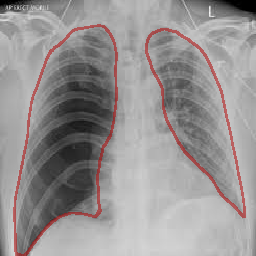

In [51]:
from io import BytesIO

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQN1zSiivS2_gcZaxjTehayv_JQultu8M9PJA&usqp=CAU"
image_url_path = get_image(url)
image_result = lineSegmentationCXR(image_url_path)
image_result

In [55]:
file = open("segmentation.jpg", "wb")
img_byte_arr = BytesIO()
image_result.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()
file.write(img_byte_arr)
file.close()

b'\x00\x00\x00\xff\x01\x01\x01\xff\x02\x02\x02\xff\x03\x03\x03\xff\x03\x03\x03\xff\x01\x01\x01\xff\x00\x00\x00\xff\x00\x00\x00\xff\x06\x06\x06\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x06\x06\x06\xff\x02\x02\x02\xff\r\r\r\xff\x0b\x0b\x0b\xff\x0b\x0b\x0b\xff&&&\xff\x14\x14\x14\xff\x1f\x1f\x1f\xff\x1b\x1b\x1b\xff+++\xff000\xff+++\xff(((\xffDDD\xffEEE\xffFFF\xffTTT\xffTTT\xffZZZ\xffWWW\xffTTT\xff[[[\xffUUU\xffYYY\xff^^^\xffkkk\xffjjj\xffbbb\xff^^^\xffkkk\xffjjj\xffbbb\xffiii\xffjjj\xffkkk\xfflll\xffnnn\xffppp\xffqqq\xffqqq\xffqqq\xffkkk\xffzzz\xff\x82\x82\x82\xff{{{\xffwww\xff|||\xff|||\xffvvv\xffyyy\xff}}}\xff{{{\xff\xb9\xb9\xb9\xff\x91\x91\x91\xffggg\xff\x80\x80\x80\xffttt\xffzzz\xff{{{\xff|||\xff~~~\xff\x80\x80\x80\xff\x82\x82\x82\xff\x82\x82\x82\xff\x84\x84\x84\xff\x85\x85\x85\xff\x9c\x9c\x9c\xff\x9d\x9d\x9d\xff\x9e\x9e\x9e\xff\x9f\x9f\x9f\xff\xa0\xa0\xa0\xff\xa1\xa1\xa1\xff\xa2\

In [41]:
img = requests.get(url)
type(img.content)

bytes